In [1]:
# Import libraries using Python 3.8

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import networkx as nx
import urllib.request
import zipfile
import networkx as nx
import osmnx as ox
import geopandas as gpd
import folium
import requests
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import cascaded_union
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from bs4 import BeautifulSoup
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter('ignore')


In [2]:
# Reading in the London Transport dataset, edges and nodes. 

df_raw = pd.read_csv(
    '../data/london_transport_raw.edges', sep=' ', header=None)

df_raw.columns = ['line', 'station_1', 'station_2']
print(df_raw.shape)
df_raw.head(2)

(503, 3)


,line,station_1,station_2
0,bakerloo,harrow&wealdstone,kenton
1,bakerloo,kenton,southkenton


In [3]:
df_raw.shape

(503, 3)

In [4]:
# Dataset of London Underground interstation train times found on this website, 
# 'https://www.whatdotheyknow.com/request/station_to_station_journey_times'


df_time = pd.read_csv(
    '../data/InterStationTrainTimes.csv', sep=',', header=None)
df_time = df_time.iloc[3: , :8]


In [5]:
# Some EDA on the dataset to join with the LT dataset.

df_time.columns = ['line', 'direction', 'station_1', 'station_2', 'distance','un-impeded','am_peak','duration']
df_time = df_time.apply(lambda x: x.str.replace(' ',''))
df_time = df_time.apply(lambda x: x.str.lower())
df_time.head(2)
df_time.shape



(1131, 8)

In [6]:
# reducing the columns to the ones needed to merge to df_raw

df_time1 = df_time[['line','station_1','station_2','duration']]
df_time1.head()

,line,station_1,station_2,duration
3,bakerloo,kenton,southkenton,2.00
4,bakerloo,southkenton,northwembley,1.50
5,bakerloo,northwembley,wembleycentral,2.06
6,bakerloo,wembleycentral,stonebridgepark,3.13
7,bakerloo,stonebridgepark,harlesden,2.40


In [7]:
# merging df_raw with the LU train times 

df_new3 = df_raw.merge(df_time1, how = 'inner', on=['line','station_1','station_2'])
df_new3.head(2)

,line,station_1,station_2,duration
0,bakerloo,kenton,southkenton,2.00
1,bakerloo,southkenton,northwembley,1.50


In [8]:
# df_raw line check

df_raw.line.unique()

array(['bakerloo', 'central', 'circle', 'district', 'hammersmith&city',
       'jubilee', 'metropolitan', 'northern', 'piccadilly', 'victoria',
       'waterloo&city', 'overground', 'dlr'], dtype=object)

In [9]:
# reading in the London Transport nodes dataset

df_nodes = pd.read_csv(
    '../data/london_transport_nodes.txt', sep=' ')
print(df_nodes.shape)
df_nodes.head()

(369, 4)


,nodeID,nodeLabel,nodeLat,nodeLong
0,0,abbeyroad,51.531952,0.003738
1,1,westham,51.528526,0.005332
2,2,actoncentral,51.508758,-0.263416
3,3,willesdenjunction,51.532234,-0.243895
4,4,actontown,51.503071,-0.280288


In [10]:
# reading in the London Transport multiplex dataset

df_multiplex = pd.read_csv(
    '../data/london_transport_multiplex.edges', sep=' ', header=None)
df_multiplex.columns = ['layer', 'node_1', 'node_2', 'weight']
print(df_multiplex.shape)
df_multiplex.head()
len(set(df_multiplex[df_multiplex.layer == 1]
        [['node_1', 'node_2']].values.flatten()))

(441, 4)


271

In [11]:
# reading in the London Transport layers dataset. This defines tube vs overground vs DLR

df_layers = pd.read_csv(
    '../data/london_transport_layers.txt', sep='\t')
df_layers['layerID'] = [int(x[0]) for x in list(df_layers.iloc[:, 0])]
df_layers['layerLabel'] = [x[2:] for x in list(df_layers.iloc[:, 0])]
df_layers.drop(df_layers.columns[0], axis=1, inplace=True)
df_layers.head()

,layerID,layerLabel
0,1,Tube (All underground lines aggregated)
1,2,Overground
2,3,DLR


In [12]:
df_multiplex[df_multiplex.layer == 1].loc[:, 'node_1':].head()

,node_1,node_2,weight
0,1,77,2
1,1,106,1
2,1,219,1
3,1,321,2
4,3,224,1


In [13]:
# adding the dataset nodes and edges together

data_1 = df_multiplex[df_multiplex.layer == 1].loc[:, 'node_1':].values
data_2 = df_multiplex[df_multiplex.layer == 2].loc[:, 'node_1':].values
data_3 = df_multiplex[df_multiplex.layer == 3].loc[:, 'node_1':].values
G_tube = nx.Graph()
G_tube.add_nodes_from(list(range(0, 369)))
G_tube.add_weighted_edges_from(data_1)

G_overground = nx.Graph()
G_overground.add_nodes_from(list(range(0, 369)))
G_overground.add_weighted_edges_from(data_2)

G_DLR = nx.Graph()
G_DLR.add_nodes_from(list(range(0, 369)))
G_DLR.add_weighted_edges_from(data_3)

G_TO = nx.Graph()
G_TO.add_nodes_from(list(range(0, 369)))
G_TO.add_weighted_edges_from(data_1)
G_TO.add_weighted_edges_from(data_2)

G_TD = nx.Graph()
G_TD.add_nodes_from(list(range(0, 369)))
G_TD.add_weighted_edges_from(data_1)
G_TD.add_weighted_edges_from(data_3)

G_OD = nx.Graph()
G_OD.add_nodes_from(list(range(0, 369)))
G_OD.add_weighted_edges_from(data_2)
G_OD.add_weighted_edges_from(data_3)

G_all = nx.Graph()
G_all.add_nodes_from(list(range(0, 369)))
G_all.add_weighted_edges_from(data_1)
G_all.add_weighted_edges_from(data_2)
G_all.add_weighted_edges_from(data_3)

In [14]:
# dictionary zipping the different layers to each other

graph_dict = dict(list(zip(['G_tube', 'G_overground', 'G_DLR', 'G_TO', 'G_TD', 'G_OD', 'G_all'],
                           [G_tube, G_overground, G_DLR, G_TO, G_TD, G_OD, G_all])))
for key in graph_dict:
    print(key)
    print(nx.info(graph_dict[key]))
    print()

G_tube
Graph with 369 nodes and 312 edges

G_overground
Graph with 369 nodes and 83 edges

G_DLR
Graph with 369 nodes and 46 edges

G_TO
Graph with 369 nodes and 384 edges

G_TD
Graph with 369 nodes and 358 edges

G_OD
Graph with 369 nodes and 129 edges

G_all
Graph with 369 nodes and 430 edges



In [15]:
# defining the three layers, edge values being added for each of tube, overground and DLR

color_labels_tube = [list(edge[2].values())[0] for edge in G_tube.edges(data=True)]
color_labels_DLR = [list(edge[2].values())[0] for edge in G_DLR.edges(data=True)]
color_labels_overground = [list(edge[2].values())[0] for edge in G_overground.edges(data=True)]

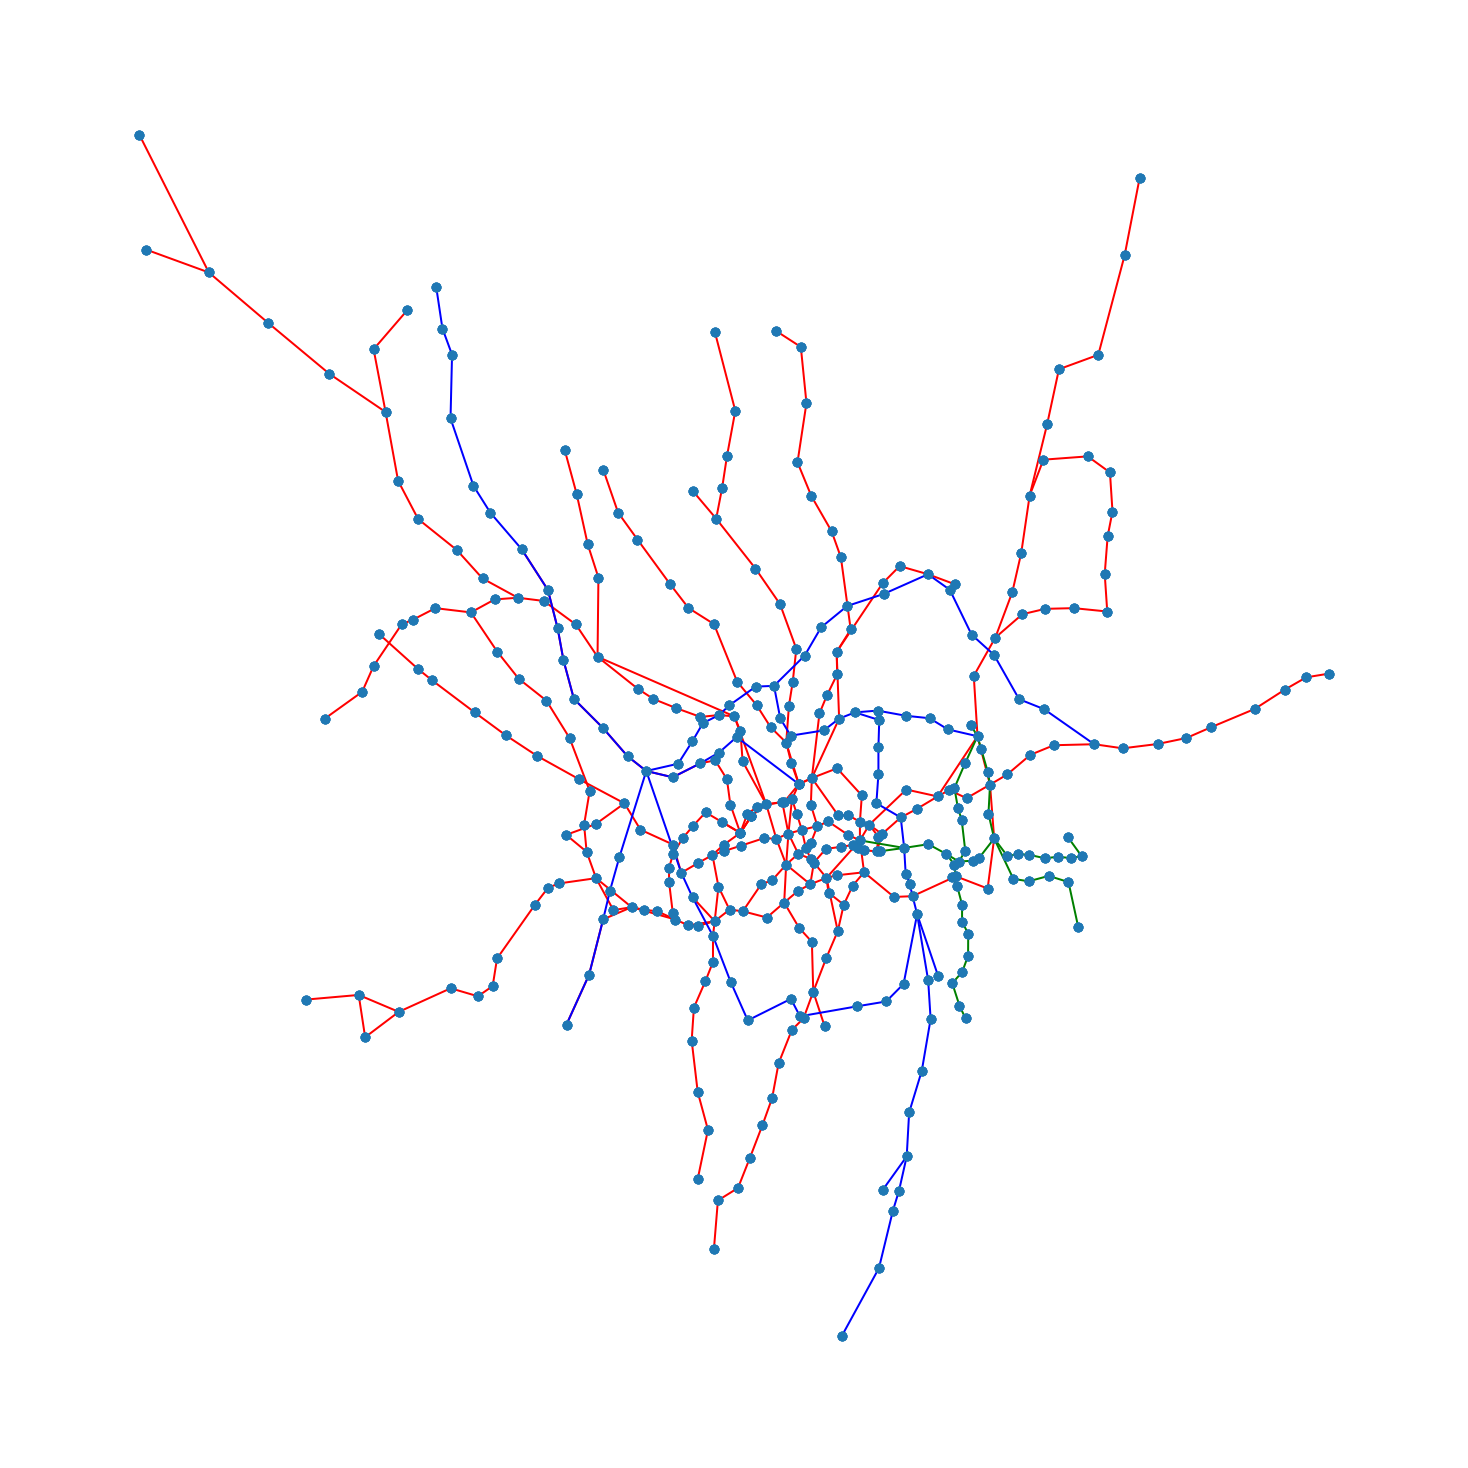

In [48]:
# Graph in networkx to show the London Transport map, and 3 layers of transport as different colours

pos_dict = {}
for key in df_nodes.nodeID:
    # list(df_nodes.iloc[key,2:])
    pos_dict[key] = list(df_nodes.loc[key, ['nodeLong', 'nodeLat']].values)

plt.figure(figsize=(10, 10))
nx.draw(G_tube, pos=pos_dict, node_size=20, edge_color='red')
nx.draw(G_overground, pos=pos_dict, node_size=20, edge_color='blue')
nx.draw(G_DLR, pos=pos_dict, node_size=20, edge_color='green')
plt.show();

This was as far as I got with the London Transport dataset in the time we had to code. The aim had been to present the transit network as above, add in train times, and then layer this into the OSMnx code below, with the final output being a search from station to GP practice, with transit route and time from one point to another. 

In [17]:
# Using OSMnx this next section imported the GP practices dataset and modelled distance times from this using isochrones

# GP Practice Data Processing
#-----------------------------------------
gp_practice_df_2 = pd.read_csv('../data/gp_pop_london_mapped_final.csv')



In [31]:
# Map visulation of London GP practices
#-----------------------------------------
frame = folium.Figure(width=500, height=500)
folium_fig = folium.Map(
    location=[51.50, -0.123],
    tiles="cartodbpositron",
    zoom_start=10).add_to(frame)
for code, name, address, number, lat, lon in zip(gp_practice_df_2['Organisation Code'],
gp_practice_df_2['Name'],
gp_practice_df_2['Address'],
gp_practice_df_2['Contact Telephone Number'],
gp_practice_df_2['Latitude'],
gp_practice_df_2['Longitude']):
    folium.Marker(
        [lat, lon],
        popup = folium.Popup('<b>' + 'Name: ' + '</b>'  + str(name) + '<br>'
        '<b>' + 'GP Practice Code: ' + '</b>' + str(code) + '<br>'
        '<b>' + 'Address: ' + '</b>' + str(address) + '<br>'
        '<b>' + 'Telephone Number: ' + '</b>' + str(number) + '<br>',
        max_width=len(address)*20),
        icon=folium.Icon(color="darkblue", prefix='fa', icon="fa-medkit"),
        ).add_to(folium_fig)
folium_fig

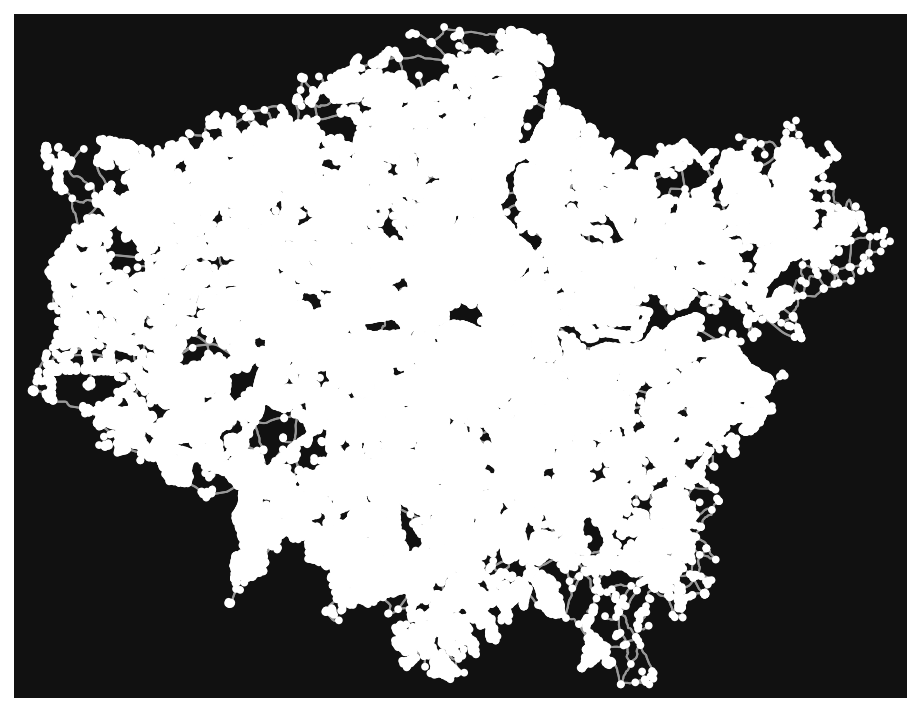

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [43]:
# Import London network and change node labels to integers, transport mode here is drive

place = "London, England"

mode = "drive"

Gp = ox.graph_from_place(place, network_type="drive")
#Gp = ox.project_graph(G)
ox.plot_graph(Gp)


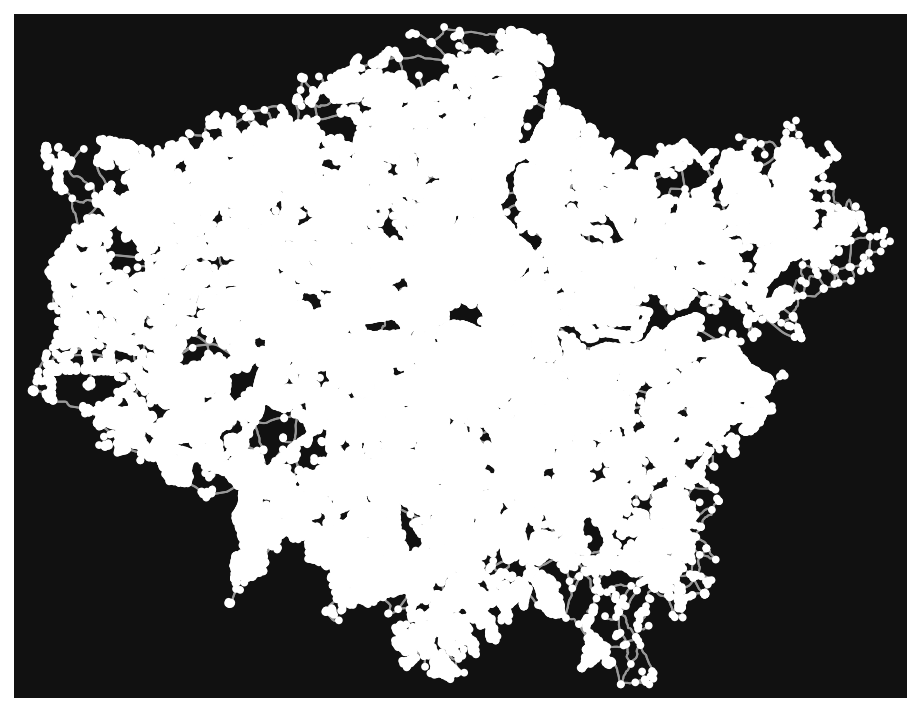

In [44]:
# As this is a London driving map, the map looks a little crowded and hard to see the data

ox.plot_graph(Gp);

In [45]:


# If a node cannot access at least 10% of other nodes, delete it (isolated)
#num_nodes = len(G.nodes)
#remove_list = []
#for node in G.nodes:  
#    reach = len(nx.descendants(G, node))
#    if reach < num_nodes / 10:
#        remove_list.append(node)

#for node in remove_list:
#    G.remove_node(node)

#G = nx.convert_node_labels_to_integers(G, label_attribute='old_node_ID')
#ox.plot_graph(G);

In [46]:
# Function to run any location, distance, transport mode, in OSMnx via the address or lat/ long points. 

def create_graph(loc, dist, transport_mode, loc_type = "address"):

    if loc_type == "address":
        G = ox.graph_from_address(loc, distance = dist, network_type = transport_mode)
    elif loc_type == "points":
        G = ox.graph_from_point(loc, distance = dist, network_type = transport_mode)
    return G

In [47]:
# This box shows the custom filter functionality in OSMnx, where other transport modes can be selected/ tried
# Default transport modes are 'walk', 'drive', 'private-hire'
# Running the OSMnx map for London, with a custom filter, selecting 'railway' or 'rail/tram' 

Gp1 = ox.graph_from_place("London, England", custom_filter='["railway"~"rail|tram"]',
 
                        retain_all=False, truncate_by_edge=True, simplify=True)
len(Gp1) 



5421

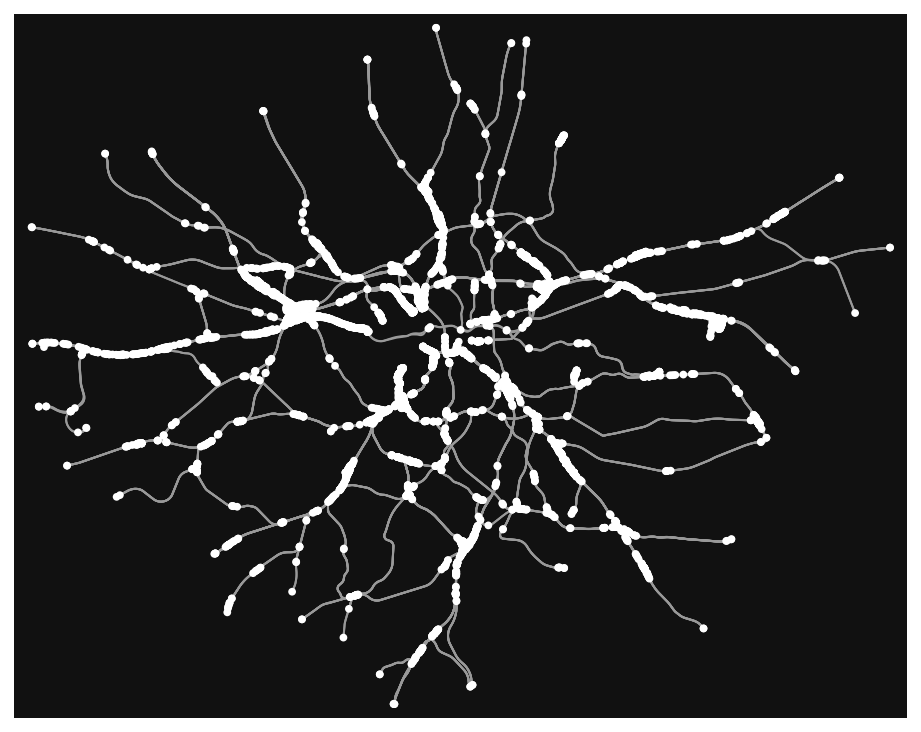

<Figure size 432x288 with 0 Axes>

In [48]:
# Plotting the output from the box above, tight layout fits the area into a small frame for easier viewing

Gp1
fig, ax = ox.plot_graph(Gp1);
plt.tight_layout()
plt.show();



In [49]:
# Adding nodes to the df

point_of_interest = ox.distance.nearest_nodes(Gp1, X = df_nodes['nodeLong'], Y=df_nodes['nodeLat'])

In [50]:
# Here adding in the isochrone trip times and travel speed for the maps

# Trip time in Mintues
trip_times = [10,20,30]

# tube speed in km/hour
travel_speed = 45.0

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in Gp1.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

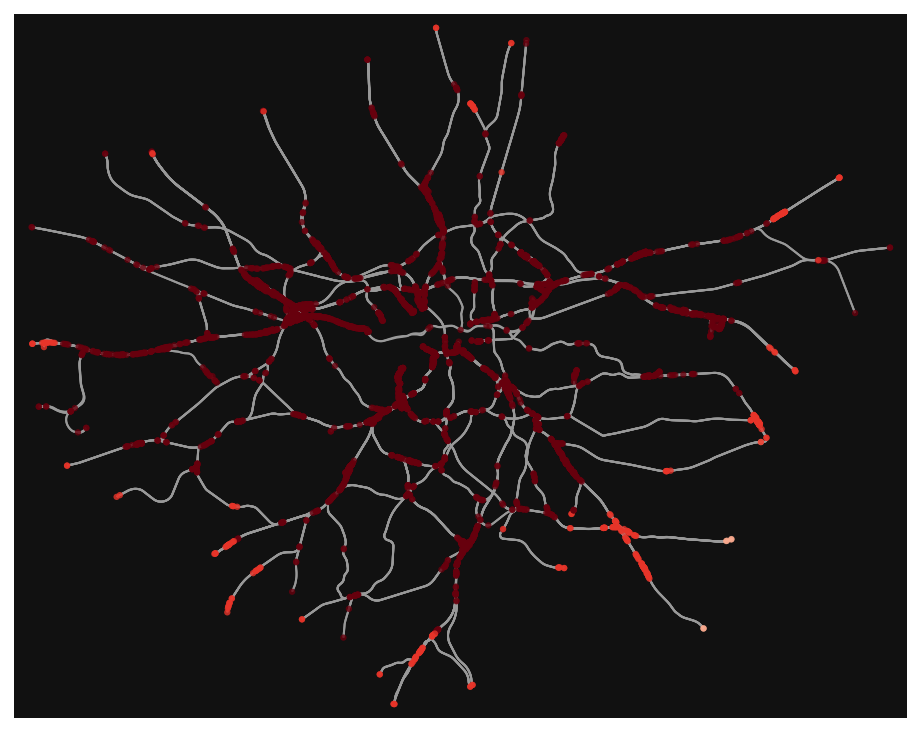

In [25]:
# Plotting the London rail transit map using OSMnx

# 1 - get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)
# 2 - color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    for points in point_of_interest:
        subgraph = nx.ego_graph(G, points, radius=trip_time, distance='time')
        for node in subgraph.nodes():
            node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [10 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

In [26]:
# make the isochrone polygons

isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    isochrone_polys_sub = []
    for points in point_of_interest:
        subgraph = nx.ego_graph(G, points, radius=trip_time, distance='time')
        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
        isochrone_polys_sub.append(bounding_poly)
    isochrone_polys.append(isochrone_polys_sub)

In [34]:
graph_map = ox.plot_graph_folium(G, folium_fig, color="#425563", opacity=0.5, weight=1)

In [ ]:
# Folium map overlayed with the isochrones

style_geojson = [
{'shape_name': '20 min walk','shape_fillColor': '#003087'},
{'shape_name': '10 min walk', 'shape_fillColor': '#005EB8'},
{'shape_name': '5 min walk', 'shape_fillColor': '#41B6E6'}]
gdf_index = list(gp_practice_df_2.index)
for polygon, style in zip(isochrone_polys, style_geojson):
     gdf = gpd.GeoDataFrame({"GP Practice": gdf_index}, geometry= polygon)
     polygon_json = list(gdf['geometry'])
     geojson = gpd.GeoSeries(cascaded_union(polygon_json)).to_json()
     fillColor = style['shape_fillColor']
     shape_name = style['shape_name']
     folium.GeoJson(geojson, name = shape_name, style_function = lambda x, fillColor = fillColor: {
            "fillColor": fillColor,
            "name":  shape_name,
            "weight": 1,
            "fillOpacity": 0.5,
            "color": "#000000"
            }).add_to(folium_fig)

In [1]:
# Folium map of London GP practices

folium.LayerControl().add_to(folium_fig)
folium_fig

NameError: name 'folium' is not defined

In [38]:
# Working out diameters/ distances in the London Transport transit map, connecting the three layers

G_tube_connected = [G_tube.subgraph(G) for G in nx.connected_components(
    G_tube) if G_tube.subgraph(G).number_of_nodes() > 1][0]
G_overground_connected = [G_overground.subgraph(G) for G in nx.connected_components(
    G_overground) if G_overground.subgraph(G).number_of_nodes() > 1][0]
G_DLR_connected = [G_DLR.subgraph(G) for G in nx.connected_components(
    G_DLR) if G_DLR.subgraph(G).number_of_nodes() > 1][0]
G_all_connected = [G_all.subgraph(G) for G in nx.connected_components(
    G_all) if G_all.subgraph(G).number_of_nodes() > 1][0]

connected_graphs = [G_tube_connected,
                    G_overground_connected, G_DLR_connected, G_all_connected]

for G in connected_graphs:
    print(nx.diameter(G))

39
35
23
39


In [39]:
# Function to define shortest path in the London Transport node network graph

def your_shortest_path(G, start_station, end_station, df_nodes=df_nodes, df_raw=df_raw):
    nodecheck = 1
    try:
        start_node = int(df_nodes.nodeID[df_nodes.nodeLabel == start_station])
    except:
        print('Your start point does not exist.')
        nodecheck = 0
    try:
        end_node = int(df_nodes.nodeID[df_nodes.nodeLabel == end_station])
    except:
        print('Your start point does not exist.')
        nodecheck = 0
    if nodecheck == 1:
        try:
            pathlength = nx.shortest_path_length(G, start_node, end_node)
            path = nx.shortest_path(G, start_node, end_node)
            print("The shortest path from {} to {} crosses".format(
                start_station, end_station), end=' ')
            print((', ').join(list(df_nodes.nodeLabel[path])[1:-1])+".")
            print("The path length is", str(pathlength)+'.')
            print("You will have to take the following lines:")
            connection = list(
                df_nodes.nodeLabel[nx.shortest_path(G, start_node, end_node)])
            lines = []
            for i in range(len(connection)-1):
                conn = list(df_raw.line[((df_raw.station_1 == connection[i]) & (df_raw.station_2 == connection[i+1])) |
                                        ((df_raw.station_1 == connection[i+1]) & (df_raw.station_2 == connection[i]))])
                if len(conn) > 1:
                    conn = (' or ').join(conn)
                else:
                    conn = conn[0]
                if conn not in lines:
                    lines.append(conn)
            print((', ').join(lines))
        except:
            print("There is no path between {} and {}.".format(
                start_station, end_station))

In [40]:
# Sample of this function working. Here to use this, input any two stations in the network

your_shortest_path(G_all, 'stjohnswood', 'cockfosters')

The shortest path from stjohnswood to cockfosters crosses bakerstreet, greatportlandstreet, eustonsquare, kingscrossstpancras, highbury&islington, finsburypark, manorhouse, turnpikelane, woodgreen, boundsgreen, arnosgrove, southgate, oakwood.
The path length is 14.
You will have to take the following lines:
jubilee, circle or hammersmith&city or metropolitan, victoria, piccadilly


In [41]:
# Second example 

your_shortest_path(G_all, 'warrenstreet', 'victoria')

The shortest path from warrenstreet to victoria crosses oxfordcircus, greenpark.
The path length is 3.
You will have to take the following lines:
victoria
